![](https://img.evbuc.com/https%3A%2F%2Fcdn.evbuc.com%2Fimages%2F33408608%2F38309748108%2F1%2Foriginal.jpg?w=1000&rect=379%2C46%2C1366%2C683&s=8fc2ce5c141e04f89f8125cd6e24ec17)

## Face Detection with OpenCV

In this Jupyter notebook, we'll be taking a look at facial recognition functionality from the top three cloud service providers (Google Compute Platform, Microsoft Azure, and Amazon Web Services). We will then be taking the first step in rolling our own face detection API with OpenCV.

_Note:_ the three proprietary APIs use neural networks as opposed to boosted cascades.

==========================================

#### Face Detection Analysis
* Google Compute Platform - _Vision API_
* Microsoft Azure - _Cognitive Services Face API_
* Amazon Web Services - _Rekognition_

Check out the supporting Jupyter notebook here. Of particular note: emotion, age, and features in three dimensions, as opposed to just two.

===========================================

## Rolling Your Own API: Face Detection

In [35]:
# Import required libraries.

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Allows matplotlib graphic output to be displayed in Jupyter notebooks.
%matplotlib inline

In [10]:
# Helper function to convert pictures to BGR color space.

def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Picture 1: Exploring BGR and RGB Color Spaces

![](heroes.jpg)

When you load an image using OpenCV, it loads it into the BGR color space by default. To show the true-colored image using `matplotlib`, we have to convert the image to the RGB color space. The helper function we created above (`convertToRGB`) does just that.

* **cv2.cvtColor**: converts images to alternate color spaces. It takes as input an image to transform and a color space code (like cv2.COLOR_BGR2RGB), and returns the processed image.

RGB stands for Red-Green-Blue. Most often, an RGB color is stored in a structure or unsigned integer with Blue occupying the least significant "area" (a byte in 32-bit and 24-bit formats), Green the second least, and Red the third least.

BGR is the same, except the order of areas is reversed. Red occupies the least significant area, Green the second (still), and Blue the third. 

What does that look like in practice? Well...

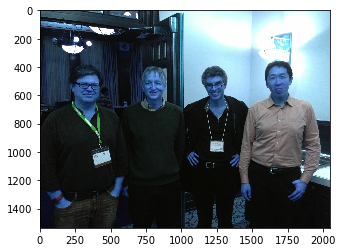

In [34]:
test1 = cv2.imread('C:\\Users\\pabailey\\Desktop\\heroes.jpg')
plt.imshow(test1)

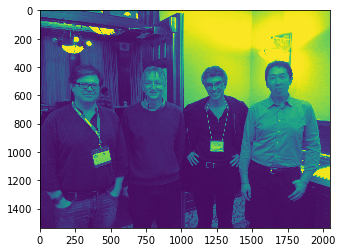

In [43]:
gray_img = cv2.cvtColor(test1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img)

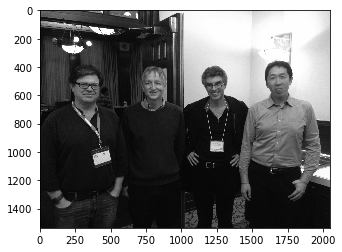

In [44]:
plt.imshow(gray_img, cmap='gray')

### First Pass - _Face and Eye Detection, Using Haar Cascades_

The Haar feature-based cascade classifier is an object detection method - for anything, not just faces - proposed by Paul Viola and Michael Jones in their paper, _Rapid Object Detection using a Boosted Cascade of Simple Features_ (2001). In this machine learning based approach, a cascade function is trained from many positive (contains the object) and negative (does not contain the object) images. The trained classifier is then used to detect similar objects in other images.


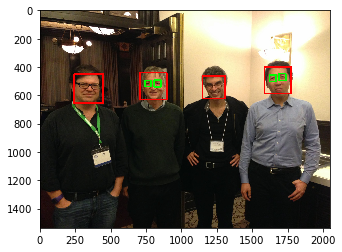

In [12]:
haar_face_cascade = cv2.CascadeClassifier('C:\\Users\\pabailey\\Desktop\\opencv\\opencv-master\\data\\haarcascades\\haarcascade_frontalface_alt.xml')
haar_eye_cascade = cv2.CascadeClassifier('C:\\Users\\pabailey\\Desktop\\opencv\\opencv-master\\data\\haarcascades\\haarcascade_eye.xml')

img = cv2.imread('C:\\Users\\pabailey\\Desktop\\heroes.jpg') # load image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale

faces = haar_face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),10)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = haar_eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),10)

plt.imshow(convertToRGB(img))

## Second Pass - _Face Detection and Eye Detection, refined_

As you can see in the analyzed image below, Haar Cascades is still having difficulty with eye placement - even with almost perfectly full-frontal faces. Neither of Yoshua Bengio's eyes are detected accurately, while Geoffrey Hinton and Andrew Ng's are double-counted as both left and right, simultaneously.

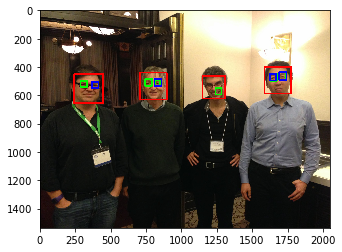

In [17]:
haar_face_cascade = cv2.CascadeClassifier('C:\\Users\\pabailey\\Desktop\\opencv\\opencv-master\\data\\haarcascades\\haarcascade_frontalface_alt.xml')
haar_right_eye_cascade = cv2.CascadeClassifier('C:\\Users\\pabailey\\Desktop\\opencv\\opencv-master\\data\\haarcascades\\haarcascade_righteye_2splits.xml')
haar_left_eye_cascade = cv2.CascadeClassifier('C:\\Users\\pabailey\\Desktop\\opencv\\opencv-master\\data\\haarcascades\\haarcascade_lefteye_2splits.xml')

img = cv2.imread('C:\\Users\\pabailey\\Desktop\\heroes.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = haar_face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),10)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
    eyes_right = haar_right_eye_cascade.detectMultiScale(roi_gray)
    eyes_left = haar_left_eye_cascade.detectMultiScale(roi_gray)
    
    for (ex,ey,ew,eh) in eyes_right:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),10)
    
    for (ex, ey, ew, eh) in eyes_left:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew, ey+eh), (255,0,0), 10)
    

plt.imshow(convertToRGB(img))

### This is the 3rd time: write a faceDetect function.
We'll be using `detectMultiScale`, which detects objects (in this case, faces) of different sizes in the input image. The detected objects are returned as a list of rectangles. Some parameters that should be tweaked, based on input images:

* **cascade** – Haar classifier cascade (OpenCV 1.x API only). It can be loaded from XML or YAML file using Load(). When the cascade is not needed anymore, release it using cvReleaseHaarClassifierCascade(&cascade).

* **image** – Matrix of the type CV_8U containing an image where objects are detected.

* **objects** – Vector of rectangles where each rectangle contains the detected object.

* **scaleFactor** – Parameter specifying how much the image size is reduced at each image scale.

* **minNeighbors** – Parameter specifying how many neighbors each candidate rectangle should have to retain it.

* **flags** – Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.

* **minSize** – Minimum possible object size. Objects smaller than that are ignored.

* **maxSize** – Maximum possible object size. Objects larger than that are ignored.

`scaleFactor` will be the most important, for this image. We initially have the value set to 1.1; but, to detect the maximum number of faces possible (in this case, three out of four) we will need to change the value of `scaleFactor` to 1.025.

In [39]:
def faceDetect(f_cascade, colored_img, scaleFactor = 1.1):
    img_copy = colored_img.copy()
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    faces = f_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=5);

    for (x, y, w, h) in faces:
        cv2.rectangle(img_copy, (x,y), (x+w,y+h), (0,255,0), 15)
    
    return img_copy

### Parameter Tweaking - `scaleFactor`

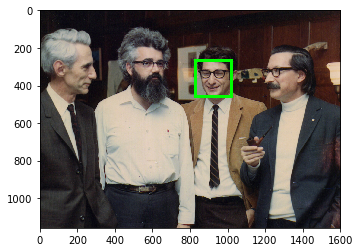

In [40]:
# Stress testing -show that you need to change parameter in function
# above to get the algorithm to see our dudes

test2 = cv2.imread('C:\\Users\\pabailey\\coolpeoplehangingouttogether.jpg')
faces_detected_img = faceDetect(haar_face_cascade, test2)
plt.imshow(convertToRGB(faces_detected_img))

### Trying a Different Algorithm - _LBP Cascades_
LBP (Local Binary Pattern) Cascades is more optimized for speed, but performs poorly on this particular input image. 

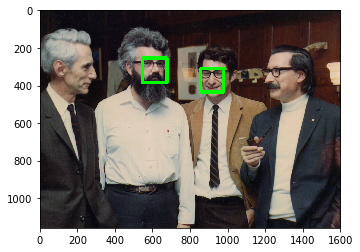

In [41]:
lbp_face_cascade = cv2.CascadeClassifier('C:\\Users\\pabailey\\Desktop\\opencv\\opencv-master\\data\\lbpcascades\\lbpcascade_frontalface_improved.xml')
faces_detected_img2 = faceDetect(lbp_face_cascade, test2)
plt.imshow(convertToRGB(faces_detected_img2))

### Trying a Version of Haar Cascades Optimized for Profiles
Even though we're now able to pick up Weizenbaum, we're still missing McCarthy and Shannon.

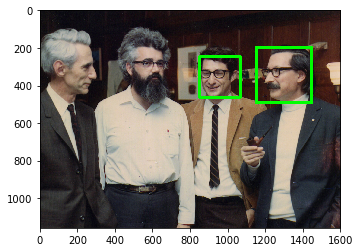

In [42]:
haar_profile_test = cv2.CascadeClassifier('C:\\Users\\pabailey\\Desktop\\opencv\\opencv-master\\data\\haarcascades\\haarcascade_profileface.xml')
faces_detected_3 = faceDetect(haar_profile_test, test2)
plt.imshow(convertToRGB(faces_detected_3))